# AI Agents with LangGraph: Lesson 6 
– Building an Essay‑Writer Agent with LangGraph

In this lesson a **multi‑agent essay‑writer** that plans, researches, writes, critiques, and iteratively improves a 5‑paragraph essay is shown.  
After this lesson best practices for *flow engineering* and point you to further resources are discussed.


**Figure: Essay Writer Flow Diagram**

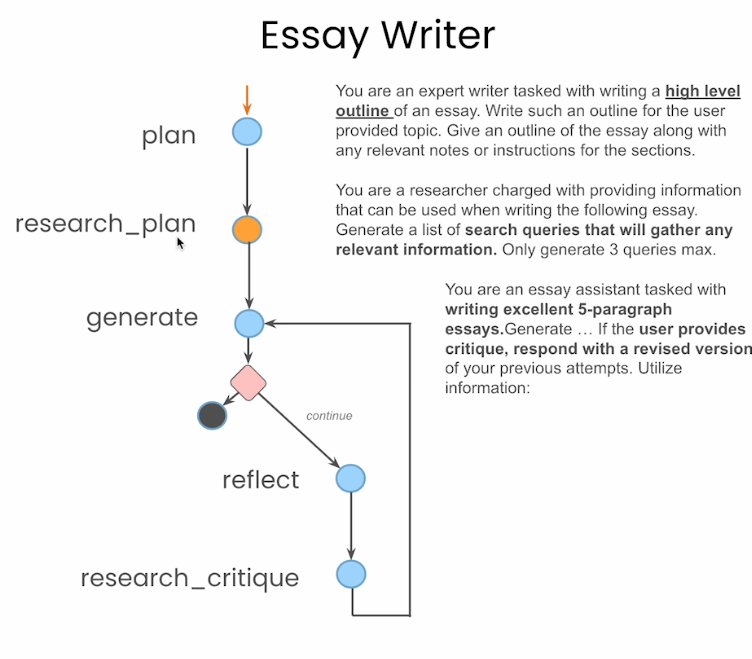

In [1]:
from IPython.display import Image, display

# Adjust the filename if you renamed it
display(Image(filename="essay_writer_flow.png", width=600))


## Learning objectives

1. **Model a shared agent state** with `TypedDict`.
2. **Compose multiple tool‑using agents** into a directed (and partially cyclic) graph with LangGraph.
3. **Gate loops with custom logic** such as a revision counter.
4. **Persist & inspect state** with LangGraph checkpointing.
5. Extend the pattern of possible research‑generation workflows.

## 1 – Imports & environment

In [2]:
from dotenv import load_dotenv
load_dotenv()  # Make sure you have OPENAI_API_KEY & TAVILY_API_KEY in a .env file

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
from typing import TypedDict, List, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.messages import AnyMessage, AIMessage, ChatMessage
from langchain_core.pydantic_v1 import BaseModel
import os, operator

# In‑memory checkpointing for this demo (swap with a file path in production)
memory = SqliteSaver.from_conn_string(":memory:")

## 2 – Defining the shared `AgentState`

In [3]:
class AgentState(TypedDict):
    """A single immutable snapshot of the multi‑agent workflow.
    Each node receives a *copy* and returns a *patch* (partial update)."""
    task: str               # original user request
    plan: str               # high‑level outline
    draft: str              # current essay draft
    critique: str           # teacher’s feedback on the draft
    content: List[str]      # research snippets gathered so far
    revision_number: int    # how many improvement cycles of generation have been completed
    max_revisions: int      # stopping criterion

## 3 – Instantiating the language model

In [4]:
model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)


## 4 – Prompt templates

In [5]:
# Prompts for planner: planning of essay outline
PLAN_PROMPT = (
    "You are an expert writer tasked with writing a high level outline of an essay. "
    "Write such an outline for the user provided topic. Give an outline of the essay along "
    "with any relevant notes or instructions for the sections."
)

# Prompts for writer: generation of essay
WRITER_PROMPT = (
    "You are an essay assistant tasked with writing excellent 5-paragraph essays. "
    "Generate the best essay possible for the user's request and the initial outline. "
    "If the user provides critique, respond with a revised version of your previous attempts. "
    "Utilize all the information below as needed:\n\n{content}"
)

# Prompts for critic: critique of essay
REFLECTION_PROMPT = (
    "You are a teacher grading an essay submission. Generate critique and recommendations "
    "for the user's submission. Provide detailed recommendations, including requests for "
    "length, depth, style, etc."
)

# Prompts for researcher: research of essay
RESEARCH_PLAN_PROMPT = (
    "You are a researcher charged with providing information that can be used when writing "
    "the following essay. Generate a list of search queries that will gather any relevant "
    "information. Only generate 3 queries max."
)

# Prompts for researcher: revision of research based on critique output (similar to researcher prompt)
RESEARCH_CRITIQUE_PROMPT = (
    "You are a researcher charged with providing information that can be used when making "
    "any requested revisions (as outlined below). Generate a list of search queries that "
    "will gather any relevant information. Only generate 3 queries max."
)

## 5 – Structured output for search queries

In [6]:
# Define a pydantic model for the queries, 
# this will be used to validate the output of the researcher agent
# the researcher agent will generate a list of queries based on the topic
# the topic will be provided by the user
class Queries(BaseModel):
    queries: List[str]

## 6 – Helper: run Tavily searches

In [7]:
# define a function to run searches, here the TavilyClient is used 

from tavily import TavilyClient

tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

## 7 – Node definitions

In [8]:
# define a plan node
def plan_node(state: AgentState):
    """Generate a plan for the essay."""
    # the plan will be used to generate the essay
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state["task"]),
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [9]:
# define a research plan node
def research_plan_node(state: AgentState):
    # generate a list of queries based on the plan
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    # run the searches
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [10]:
# define a generation node
def generation_node(state: AgentState):
    """Write (or rewrite) the essay."""
    research_blob = "\n\n".join(state.get("content") or [])
    user_msg = HumanMessage(content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(content=WRITER_PROMPT.format(content=research_blob)),
        user_msg,
    ]
    response = model.invoke(messages)
    # Increment the revision counter (default to 1 if missing)
    next_num = state.get("revision_number", 1) + 1
    return {"draft": response.content, "revision_number": next_num}

In [11]:
# define a reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state["draft"]),
    ]
    # generate a critique of the draft
    response = model.invoke(messages)
    return {"critique": response.content}


In [12]:
# define a research critique node
def research_critique_node(state: AgentState):
    # generate a list of queries based on the critique
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}


## 8 – Loop‑control callback

In [13]:
def should_continue(state: AgentState):
    """Stop when we have exceeded the allowed revisions."""
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

## 9 – Assembling the `StateGraph`

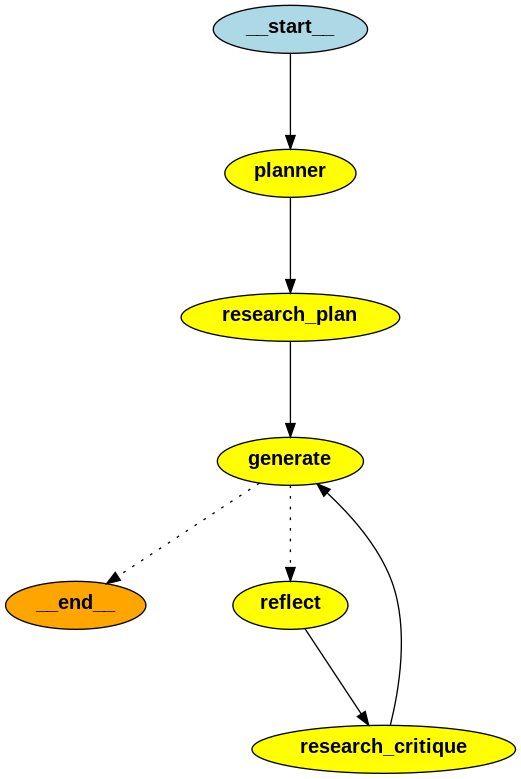

In [14]:
# define the graph
builder = StateGraph(AgentState)
# add nodes
builder.add_node("planner", plan_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_critique", research_critique_node)

# define the entry point of the graph
builder.set_entry_point("planner")

# define the edges of the graph
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")
# add conditional edges
builder.add_conditional_edges("generate", should_continue, {END: END, "reflect": "reflect"})
builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

# Compile
graph = builder.compile(checkpointer=memory)

# Visualise programmatically the created graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_png()))


## 10 – Running an example
Below we fire up a new thread and stream intermediate states.  
Feel free to change the `task` or `max_revisions` and re‑run!

In [15]:
# run the graph
thread = {"configurable": {"thread_id": "1"}}

for patch in graph.stream(
    {
        "task": "What is the difference between LangChain and LangSmith?",
        "max_revisions": 2,
        "revision_number": 1,
    },
    thread,
):
    # Pretty‑print the step name and keys updated
    print(patch)

{'planner': {'plan': 'I. Introduction\n    A. Brief overview of LangChain and LangSmith\n    B. Importance of understanding the differences between the two\n\nII. LangChain\n    A. Definition and purpose\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIII. LangSmith\n    A. Definition and purpose\n    B. Key features and characteristics\n    C. Use cases and applications\n    D. Advantages and disadvantages\n\nIV. Comparison between LangChain and LangSmith\n    A. Technology stack\n    B. Scalability\n    C. Security\n    D. Performance\n    E. Cost-effectiveness\n\nV. Conclusion\n    A. Recap of the main differences between LangChain and LangSmith\n    B. Implications for businesses and developers\n    C. Future outlook for both technologies'}}
{'research_plan': {'content': ['LangChain is not limited to out-of-the-box foundation models: the CustomLLM class\xa0(link resides outside ibm.com) allows for custom LLM wrappe

{'generate': {'draft': "**Title: Understanding the Distinction Between LangChain and LangSmith**\n\nI. Introduction\nIn the realm of AI application development, LangChain and LangSmith play pivotal roles. It is essential to comprehend the disparities between these two technologies to harness their full potential effectively.\n\nII. LangChain\nLangChain serves as an open-source framework tailored to streamline the creation of applications utilizing language models. Its key features include seamless integration with various NLP components, aiding in the development and deployment of robust applications. LangChain finds applications in diverse fields, offering a comprehensive solution for managing the lifecycle of NLP models. While it provides flexibility, it may have certain limitations in terms of scalability.\n\nIII. LangSmith\nContrastingly, LangSmith functions as a monitoring and testing tool specifically designed for LLM applications in production. It focuses on agent observability 

{'generate': {'draft': '**Title: Understanding the Distinction Between LangChain and LangSmith**\n\nI. Introduction\nIn the realm of AI application development, LangChain and LangSmith play pivotal roles in managing and optimizing language models. Understanding the nuances between these two tools is essential for leveraging their capabilities effectively.\n\nII. LangChain\nLangChain serves as a modular framework for building AI applications by integrating various components like language models and data sources. Its key features include accelerated development, modular architecture, and seamless integration with external resources. LangChain finds applications in chatbots, workflow automation, and text analysis, offering advantages such as enhanced context management and streamlined processes.\n\nIII. LangSmith\nOn the other hand, LangSmith focuses on monitoring and testing LLM applications in production. It provides tools for analyzing, debugging, and optimizing workflows, offering de

## 11 – Further reading & next steps
* **LangChain documentation** – dive deeper into models, tools, and agents: <https://python.langchain.com>
* **LangGraph repo** – design patterns for flow engineering: <https://github.com/langchain-ai/langgraph>
* **Tavily** – fast web search API: <https://docs.tavily.com/>
* **Flow engineering primer** – explore plan‑&‑execute, supervisor models, and tree‑search workflows.



| Pattern                            | Core Idea                                                                                                                                                                                                   | When to Use                                                                                                                                                 | Typical Shape                                                                                                 |
| ---------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- |
| **Shared-state multi-agent**       | Several peer agents (planner, researcher, writer, critic ...) read/write the **same AgentState**. Control flow is expressed as a graph; each node patches the state.                                       | Collaborative tasks where specialists iteratively improve a single artefact (e.g. our Essay-Writer, multi-turn coding assistants).                          | Directed graph with optional cycles; checkpoints let you branch, rewind, or inspect any snapshot.             |
| **Supervisor / Router**            | A top-level *supervisor* agent receives the user request, decides **which sub-agent to call next and with what input**, then aggregates or routes the response. Sub-agents don’t see the full global state. | Complex orchestration where only one tool/agent should act at a time (e.g. customer-support copilots choosing between FAQ search, booking API, escalation). | Star topology – supervisor in the centre, sub-agents on spokes.                                               |
| **Plan-and-Execute**               | First produce an explicit, immutable **plan**. Then execute steps sequentially (or in small branches) until the plan is exhausted or success criteria met.                                                  | Tasks that benefit from high-level decomposition where execution is expensive (research reports, long-form code generation).                                | Linear flow with an upfront “plan” node; may include a post-hoc evaluation loop.                              |
| **Directed-flow with local loops** | Overall pipeline is mostly acyclic **except for a few carefully-gated iterations** (e.g. *draft → test → fix*). Loops are kept small to avoid sprawling graphs.                                             | Scenarios like **AlphaCodium**: generate code once, then loop on *public-tests* or *AI-tests* until passing.                                                | One or two nodes feed back into an earlier stage; loop exit uses counters, scores, or convergence heuristics. |
| **Tree-Search / Branch-and-Bound** | Explore multiple action branches in parallel; **reflect/evaluate** at each depth; back-propagate rewards to prune bad branches (see *Language Agent Tree Search* paper).                                    | Open-ended reasoning where many solution paths exist (puzzle solving, theorem proving, complex planning).                                                   | Tree of states; reflection node scores leaves; search policy selects next frontier.                           |
| **Score-based Reflex Loops**       | After each iteration compute an **objective score** (e.g. rubric ≥ 90 %, ROUGE, unit-test pass-rate). Continue looping until threshold is hit, then terminate.                                              | Automated quality assurance where a quantitative metric is available.                                                                                       | generate → score → (stop \| more-research / fix)                                                            |
| **Checkpoint-centric Time-Travel** | Persist every state to durable storage so the user (or another agent) can **rewind to any snapshot**, modify the state (e.g. edit the plan), and resume the graph from there.                               | Interactive teaching tools, debugging agent flows, or exploratory research pipelines.                                                                       | Same as shared-state multi-agent, but with external checkpointer and UI controls to jump between snapshots.   |
